<a href="https://colab.research.google.com/github/Dhedeepya-09/Waste-Classification-Using-TrashNet/blob/main/Waste_Classification_with_TrashNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow==2.19.0 tensorflow-decision-forests tensorflow-text tf-keras
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [2]:
from google.colab import files
import os, shutil, glob, random, json
from pathlib import Path
print("Upload your kaggle.json (Account -> API -> Create New Token) when prompted.")
uploaded = files.upload()
if 'kaggle.json' not in uploaded:
    raise SystemExit("kaggle.json not uploaded. Re-run the cell and upload it.")
os.makedirs('/root/.kaggle', exist_ok=True)
with open('kaggle.json', 'wb') as f:
    f.write(uploaded['kaggle.json'])
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)
print("Saved kaggle.json to /root/.kaggle/kaggle.json")

Upload your kaggle.json (Account -> API -> Create New Token) when prompted.


Saving kaggle.json to kaggle.json
Saved kaggle.json to /root/.kaggle/kaggle.json


In [3]:
DATASET_SLUG = "feyzazkefe/trashnet"   # TrashNet
DOWNLOAD_DIR = "/content/downloaded_kaggle_dataset"
os.makedirs(DOWNLOAD_DIR, exist_ok=True)
print(f"Downloading {DATASET_SLUG} ...")
!kaggle datasets download -d {DATASET_SLUG} -p {DOWNLOAD_DIR} --unzip

print("Download finished. Listing top-level files:")
print(os.listdir(DOWNLOAD_DIR))

Dataset URL: https://www.kaggle.com/datasets/feyzazkefe/trashnet
License(s): unknown
  0% 0.00/40.8M [00:00<?, ?B/s]
100% 40.8M/40.8M [00:00<00:00, 1.79GB/s]
Download finished. Listing top-level files:
['dataset-resized']


In [4]:
def find_image_root(download_dir):
    # return folder that contains class subfolders with images
    for root, dirs, files in os.walk(download_dir):
        # check if subfolders contain images
        good_subdirs = 0
        for d in dirs:
            dd = os.path.join(root, d)
            if os.path.isdir(dd) and any(fname.lower().endswith(('.jpg','.jpeg','.png')) for fname in os.listdir(dd)):
                good_subdirs += 1
        if good_subdirs >= 2:
            return root
    # fallback
    return download_dir

image_root = find_image_root(DOWNLOAD_DIR)
print("Detected image root:", image_root)
print("Sample contents:", os.listdir(image_root)[:20])

Detected image root: /content/downloaded_kaggle_dataset/dataset-resized
Sample contents: ['cardboard', 'paper', 'metal', 'plastic', 'glass', 'trash']


In [5]:
class_to_images = {}
for entry in sorted(os.listdir(image_root)):
    p = os.path.join(image_root, entry)
    if os.path.isdir(p):
        imgs = [os.path.join(p, f) for f in os.listdir(p) if f.lower().endswith(('.jpg','.jpeg','.png','.bmp'))]
        if imgs:
            class_to_images[entry] = sorted(imgs)

# fallback: search deeper
if not class_to_images:
    for root, dirs, files in os.walk(image_root):
        imgs = [os.path.join(root,f) for f in files if f.lower().endswith(('.jpg','.jpeg','.png','.bmp'))]
        if imgs:
            cls = os.path.basename(root)
            class_to_images.setdefault(cls, []).extend(sorted(imgs))

if not class_to_images:
    raise SystemExit("No images found in the downloaded dataset. Inspect /content/downloaded_kaggle_dataset")

print("Classes found:", list(class_to_images.keys()))

Classes found: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [6]:
from sklearn.model_selection import train_test_split
TARGET = "/content/dataset"
if os.path.exists(TARGET):
    shutil.rmtree(TARGET)
os.makedirs(TARGET, exist_ok=True)

seed = 42
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

for cls, imgs in class_to_images.items():
    n = len(imgs)
    if n == 0:
        continue
    # if very small class, put everything into train
    if n < 3:
        train_imgs = imgs
        val_imgs, test_imgs = [], []
    else:
        train_imgs, temp = train_test_split(imgs, train_size=train_ratio, random_state=seed, shuffle=True)
        if len(temp) >= 2:
            # split temp into val and test proportional to val_ratio/test_ratio
            val_size = val_ratio / (val_ratio + test_ratio)
            val_imgs, test_imgs = train_test_split(temp, train_size=val_size, random_state=seed, shuffle=True)
        else:
            val_imgs = temp
            test_imgs = []
    for split_name, files_list in (("train", train_imgs), ("val", val_imgs), ("test", test_imgs)):
        out_dir = os.path.join(TARGET, split_name, cls)
        os.makedirs(out_dir, exist_ok=True)
        for src in files_list:
            try:
                shutil.copy(src, out_dir)
            except Exception as e:
                print("Copy error:", e, src)

print("Dataset prepared at /content/dataset")
for s in ['train','val','test']:
    print(s + " counts:")
    for cls in sorted(class_to_images.keys()):
        d = os.path.join(TARGET, s, cls)
        c = len(os.listdir(d)) if os.path.exists(d) else 0
        print(f"  {cls}: {c}")

Dataset prepared at /content/dataset
train counts:
  cardboard: 282
  glass: 350
  metal: 287
  paper: 415
  plastic: 337
  trash: 95
val counts:
  cardboard: 60
  glass: 75
  metal: 61
  paper: 89
  plastic: 72
  trash: 21
test counts:
  cardboard: 61
  glass: 76
  metal: 62
  paper: 90
  plastic: 73
  trash: 21


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (224, 224)   # MobileNetV2 prefers 224x224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train_gen = train_datagen.flow_from_directory(
    os.path.join(TARGET, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(TARGET, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_datagen.flow_from_directory(
    os.path.join(TARGET, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = train_gen.num_classes
print("Num classes:", NUM_CLASSES)
print("Class indices:", train_gen.class_indices)

Found 1766 images belonging to 6 classes.
Found 378 images belonging to 6 classes.
Found 383 images belonging to 6 classes.
Num classes: 6
Class indices: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [8]:
from tensorflow.keras import layers, models, optimizers

base_model = tf.keras.applications.MobileNetV2(input_shape=(*IMG_SIZE,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False   # freeze base initially

inputs = layers.Input(shape=(*IMG_SIZE,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,462 (9.87 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
EPOCHS_HEAD = 8
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_waste_mobilenetv2.h5', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
]

history_head = model.fit(
    train_gen,
    epochs=EPOCHS_HEAD,
    validation_data=val_gen,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.4926 - loss: 1.4254

56/56 ━━━━━━━━━━━━━━━━━━━━ 66s 856ms/step - accuracy: 0.4946 - loss: 1.4191 - val_accuracy: 0.7566 - val_loss: 0.6096
Epoch 2/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.7612 - loss: 0.6730

56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 396ms/step - accuracy: 0.7611 - loss: 0.6732 - val_accuracy: 0.7778 - val_loss: 0.5897
Epoch 3/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.8138 - loss: 0.5326

56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 470ms/step - accuracy: 0.8136 - loss: 0.5329 - val_accuracy: 0.8148 - val_loss: 0.4821
Epoch 4/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8127 - loss: 0.5071

56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 414ms/step - accuracy: 0.8127 - loss: 0.5069 - val_accuracy: 0.8254 - val_loss: 0.4623
Epoch 5/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.8542 - loss: 0.3922

56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 400ms/step - accuracy: 0.8540 - loss: 0.3930 - val_accuracy: 0.8307 - val_loss: 0.4469
Epoch 6/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.8472 - loss: 0.4190

56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 384ms/step - accuracy: 0.8471 - loss: 0.4193 - val_accuracy: 0.8466 - val_loss: 0.4234
Epoch 7/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 392ms/step - accuracy: 0.8709 - loss: 0.3673 - val_accuracy: 0.8413 - val_loss: 0.4392
Epoch 8/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 407ms/step - accuracy: 0.8590 - loss: 0.3746 - val_accuracy: 0.8307 - val_loss: 0.4414


In [10]:
FINE_TUNE = True
if FINE_TUNE:
    # Unfreeze the top layers of base_model
    base_model.trainable = True
    # Fine-tune from this layer onwards (tweak as needed)
    fine_tune_at = 100  # try 100 or 140 depending on base_model.layers length
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    EPOCHS_FINE = 8
    history_fine = model.fit(
        train_gen,
        epochs=EPOCHS_FINE,
        validation_data=val_gen,
        callbacks=callbacks
    )
    # Merge histories for plotting
    def merge_hist(h1, h2):
        merged = {}
        for k in set(list(h1.history.keys()) + list(h2.history.keys())):
            merged[k] = h1.history.get(k, []) + h2.history.get(k, [])
        return merged
    history = type('H', (), {'history': merge_hist(history_head, history_fine)})
else:
    history = history_head

Epoch 1/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.6678 - loss: 0.9074

56/56 ━━━━━━━━━━━━━━━━━━━━ 65s 736ms/step - accuracy: 0.6685 - loss: 0.9054 - val_accuracy: 0.8545 - val_loss: 0.4106
Epoch 2/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.7670 - loss: 0.6173

56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 387ms/step - accuracy: 0.7671 - loss: 0.6171 - val_accuracy: 0.8439 - val_loss: 0.4103
Epoch 3/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 388ms/step - accuracy: 0.7968 - loss: 0.5801 - val_accuracy: 0.8413 - val_loss: 0.4125
Epoch 4/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 385ms/step - accuracy: 0.8154 - loss: 0.5173 - val_accuracy: 0.8519 - val_loss: 0.4146
Epoch 5/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 386ms/step - accuracy: 0.8158 - loss: 0.5055 - val_accuracy: 0.8519 - val_loss: 0.4139
Epoch 6/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.8189 - loss: 0.4741

56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 383ms/step - accuracy: 0.8191 - loss: 0.4738 - val_accuracy: 0.8439 - val_loss: 0.4081
Epoch 7/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 384ms/step - accuracy: 0.8412 - loss: 0.4375 - val_accuracy: 0.8545 - val_loss: 0.4095
Epoch 8/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8522 - loss: 0.3965

56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 392ms/step - accuracy: 0.8523 - loss: 0.3963 - val_accuracy: 0.8466 - val_loss: 0.4081


In [11]:
model.save("waste_mobilenetv2.h5")
print("Saved final model: waste_mobilenetv2.h5  (best model saved as best_waste_mobilenetv2.h5)")

Saved final model: waste_mobilenetv2.h5  (best model saved as best_waste_mobilenetv2.h5)


In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

if test_gen.samples > 0:
    steps = int(np.ceil(test_gen.samples / test_gen.batch_size))
    preds_proba = model.predict(test_gen, steps=steps)
    preds = np.argmax(preds_proba, axis=1)
    y_true = test_gen.classes

    acc = accuracy_score(y_true, preds)
    prec = precision_score(y_true, preds, average='macro', zero_division=0)
    rec = recall_score(y_true, preds, average='macro', zero_division=0)
    f1 = f1_score(y_true, preds, average='macro', zero_division=0)

    print(f"\nTest Accuracy : {acc:.4f}")
    print(f"Precision (macro) : {prec:.4f}")
    print(f"Recall (macro) : {rec:.4f}")
    print(f"F1 score (macro) : {f1:.4f}\n")

    class_names = list(train_gen.class_indices.keys())
    print("Classification Report:\n")
    print(classification_report(y_true, preds, target_names=class_names, zero_division=0))
else:
    print("No test images found; skipping evaluation.")

12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step

Test Accuracy : 0.8277
Precision (macro) : 0.8030
Recall (macro) : 0.8079
F1 score (macro) : 0.8022

Classification Report:

              precision    recall  f1-score   support

   cardboard       1.00      0.87      0.93        61
       glass       0.82      0.78      0.80        76
       metal       0.73      0.89      0.80        62
       paper       0.90      0.92      0.91        90
     plastic       0.80      0.73      0.76        73
       trash       0.56      0.67      0.61        21

    accuracy                           0.83       383
   macro avg       0.80      0.81      0.80       383
weighted avg       0.84      0.83      0.83       383



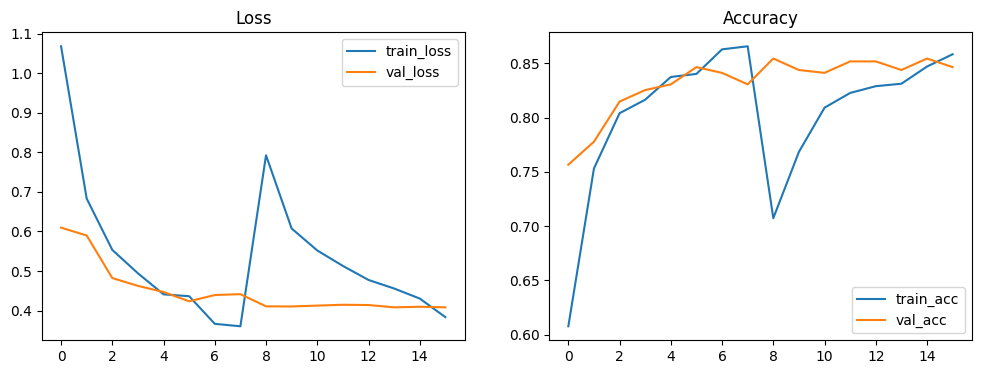

Done. Models: /content/waste_mobilenetv2.h5 and /content/best_waste_mobilenetv2.h5


In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()

print("Done. Models: /content/waste_mobilenetv2.h5 and /content/best_waste_mobilenetv2.h5")